### Импорт и методы

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, r2_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
#import xgboost as xgb
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#DATA_ROOT = Path('./data/training_project/')
MODELS_PATH = Path('./models/')

# input
#DATASET_PATH = DATA_ROOT / 'train.csv'
#PREP_DATASET_PATH = DATA_ROOT / 'train_prep.csv'

# output
TRAIN_PATH = './train.csv'
#TRAIN_PART_PATH = DATA_ROOT / 'training_project_train_part_b.csv'
TEST_PATH = './test.csv'

#SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'
FINAL_MODEL_FILE_PATH = MODELS_PATH / 'final_model.pkl'

In [3]:
class ClearFeature():
    
    def __init__(self):
        pass
    
        
    def transform(self, X):
        X = self.change_val(X, 'Years in current job', 'Years_on_curr_job') 
        X = self.change_val(X, 'Home Ownership', 'Home_ownership')
        X = self.change_val(X, 'Purpose', 'Purpose_')
        X = self.change_val(X, 'Term', 'Term_')
        X['Years_on_curr_job'] = X['Years_on_curr_job'].apply(np.int)
        X['Home_ownership'] = X['Home_ownership'].apply(np.int)
        X['Purpose_'] = X['Purpose_'].apply(np.int)
        X['Term_'] = X['Term_'].apply(np.int)
        X['Home_ownership'] = X['Home_ownership'].apply(np.int)
        X['Number of Open Accounts'] = X['Number of Open Accounts'].round(0).apply(np.int) #astype(int)
        X['Number of Credit Problems'] = X['Number of Credit Problems'].round(0).apply(np.int) #astype(int)
        return X



    
    @staticmethod
    def change_val(X, old_label, new_label):
        i = 1
        X[new_label] = -1
        values = list(X[old_label].unique())
        print(values)
        for v in values:
            X.loc[X[old_label] == v, new_label] = i
            i += 1
        return X


In [4]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [8]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [9]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [10]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [11]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [12]:
def log_hist_plot(df, bins):
    fig, ax = plt.subplots()
    df.hist(ax=ax, bins=bins, bottom=0.1)
    ax.set_yscale('log')

In [13]:
def replace_nan(data):
    for column in data.columns:
        if data[column].isna().sum() > 0:
            data[column] = data[column].fillna(data[column].mode()[0])

In [14]:
def imputer_rfr(data, target_col, test_size_):
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    
    df_0 = data[data[target_col].isna()]
    df_1 = df_0.loc[:, data.columns != target_col]
    df_2 = df_0.loc[:, data.columns == target_col]
    predict_data = df_0.drop(columns=df_1.columns[df_1.isnull().any()])
    #predict_data = data[data[target_col].isna()]
    

    y = train[target_col]
    X = train[predict_data.columns]
    X = X.drop(columns=target_col)
    any_null_cols = X.columns[X.isnull().any()]
    X = X.drop(columns=any_null_cols)

   # print(X.isnull().any())
   # print(any_null_cols)
    predict_data = predict_data.drop(columns=any_null_cols)
    print(predict_data.info())
        
        
        
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size_,
                                                        shuffle=True,
                                                        random_state=42)
    
    param_grid = {
        'bootstrap': [True],
        'max_depth': [10, 20, 30, 40],
        'max_features': [2, 3],
        'min_samples_leaf': [2, 3, 4],
        'min_samples_split': [6, 8, 10],
        'n_estimators': [100, 200, 300, 400]
    }
    # Create a base model
    rf = RandomForestRegressor()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = 3, n_jobs = -1, verbose = 2)
    print()
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    print(f'Grid best params:\n{grid_search.best_params_}')
    print('Evaluating best model:')
    best_grid = grid_search.best_estimator_
    grid_accuracy = evaluate(best_grid, X_test, y_test)
    print()
    print('Evaluating base model:')
    base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
    base_model.fit(X_train, y_train)
    base_accuracy = evaluate(base_model, X_test, y_test)
    print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

    model = best_grid
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print()
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    
    return data, target_col, model, predict_data

In [15]:
def pred_rfr(data, target_col, model, predict_data):
    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return data

In [16]:
TARGET_NAME = 'Credit Default'

BASE_FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
                     'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                     'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts',
                     'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']


### Базовое решение<a class="anchor" id="basic_solution"></a>

In [17]:
df_train_base = pd.read_csv(TRAIN_PATH)
df_test_base = pd.read_csv(TEST_PATH)

In [18]:
df_test_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [19]:
replace_nan(df_train_base)
replace_nan(df_test_base)

In [20]:
df_train_base.isnull().values.any()

False

In [21]:
df_train_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [22]:
features_base = ClearFeature()

df_train_base = features_base.transform(df_train_base)
df_test_base = features_base.transform(df_test_base)

df_train_base.drop(CAT_FEATURE_NAMES, axis=1, inplace=True)
df_test_base.drop(CAT_FEATURE_NAMES, axis=1, inplace=True)

['10+ years', '8 years', '6 years', '7 years', '5 years', '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years']
['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage']
['debt consolidation', 'other', 'home improvements', 'take a trip', 'buy a car', 'small business', 'business loan', 'wedding', 'educational expenses', 'buy house', 'medical bills', 'moving', 'major purchase', 'vacation', 'renewable energy']
['Short Term', 'Long Term']
['4 years', '1 year', '3 years', '10+ years', '6 years', '5 years', '< 1 year', '2 years', '9 years', '8 years', '7 years']
['Rent', 'Home Mortgage', 'Own Home', 'Have Mortgage']
['debt consolidation', 'educational expenses', 'home improvements', 'major purchase', 'other', 'buy a car', 'medical bills', 'buy house', 'business loan', 'take a trip', 'small business', 'moving', 'vacation', 'wedding']
['Short Term', 'Long Term']


In [23]:
X_train_base = df_train_base.drop(columns=[TARGET_NAME])
y_train_base = df_train_base[TARGET_NAME]

In [24]:
X_train_base.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Years_on_curr_job,Home_ownership,Purpose_,Term_
0,482087.0,0.0,11,26.3,685960.0,1,14.0,1.0,99999999.0,47386.0,7914.0,749.0,1,1,1,1
1,1025487.0,0.0,15,15.3,1181730.0,0,14.0,0.0,264968.0,394972.0,18373.0,737.0,1,1,1,2
2,751412.0,0.0,11,35.0,1182434.0,0,14.0,0.0,99999999.0,308389.0,13651.0,742.0,2,2,1,1
3,805068.0,0.0,8,22.5,147400.0,1,14.0,1.0,121396.0,95855.0,11338.0,694.0,3,1,1,1
4,776264.0,0.0,13,13.6,385836.0,1,14.0,0.0,125840.0,93309.0,7180.0,719.0,2,3,1,1


In [25]:
X_train_bs, X_test_bs, y_train_bs, y_test_bs = train_test_split(X_train_base, y_train_base,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=42)

In [26]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train_bs, y_train_bs)
base_accuracy = evaluate(base_model, X_test_bs, y_test_bs)

    
pred_train_bs = base_model.predict(X_train_bs)
pred_test_bs = base_model.predict(X_test_bs)
print()
print(f"r2 на train: {r2_score(y_train_bs, pred_train_bs)}")
print(f"r2 на test: {r2_score(y_test_bs, pred_test_bs)}")

    
#pred_bs = base_model.predict(y_train_base)


bs_pred = df_test_base.drop(columns=df_test_base.columns).rename_axis('Id')
bs_pred[TARGET_NAME] = base_model.predict(df_test_base)

bs_pred.to_csv('predictions_base.csv', index=True)

bs_pred.head()

Model Performance
Average Error: 0.2547 degrees.
Accuracy = -inf%.

r2 на train: 0.9038197914547754
r2 на test: -0.22693081009552096


,Credit Default
Id,
0,0
1,0
2,1
3,0
4,0


In [27]:
## kaggle score = 0.28070 for this model

### EDA + обработка данных<a class="anchor" id="eda"></a>

In [28]:
#df = pd.read_csv(TRAIN_FULL_PATH)
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [30]:
list(df_train['Home Ownership'].unique())

['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage']

In [31]:
def change_val_(X, old_label):
    values = list(X[old_label].unique())
    print(values)
 #   return X

In [32]:
change_val_(df_train, 'Home Ownership')

['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage']


In [33]:
features = ClearFeature()

df_train = features.transform(df_train)
df_test = features.transform(df_test)

df_train.drop(CAT_FEATURE_NAMES, axis=1, inplace=True)
df_test.drop(CAT_FEATURE_NAMES, axis=1, inplace=True)

[nan, '10+ years', '8 years', '6 years', '7 years', '5 years', '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years']
['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage']
['debt consolidation', 'other', 'home improvements', 'take a trip', 'buy a car', 'small business', 'business loan', 'wedding', 'educational expenses', 'buy house', 'medical bills', 'moving', 'major purchase', 'vacation', 'renewable energy']
['Short Term', 'Long Term']
['4 years', '1 year', '3 years', '10+ years', '6 years', '5 years', '< 1 year', '2 years', '9 years', '8 years', '7 years', nan]
['Rent', 'Home Mortgage', 'Own Home', 'Have Mortgage']
['debt consolidation', 'educational expenses', 'home improvements', 'major purchase', 'other', 'buy a car', 'medical bills', 'buy house', 'business loan', 'take a trip', 'small business', 'moving', 'vacation', 'wedding']
['Short Term', 'Long Term']


In [34]:
df_train['Years_on_curr_job'].unique()

array([-1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [35]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.26 MB
Decreased by 72.8%


In [36]:
#X = df_train.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
#y = df_train[TARGET_NAME]

X_train = df_train.drop(columns=[TARGET_NAME])
y_train = df_train[TARGET_NAME]

#X_test = df_test.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
#y_test = df_test[TARGET_NAME]

In [37]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

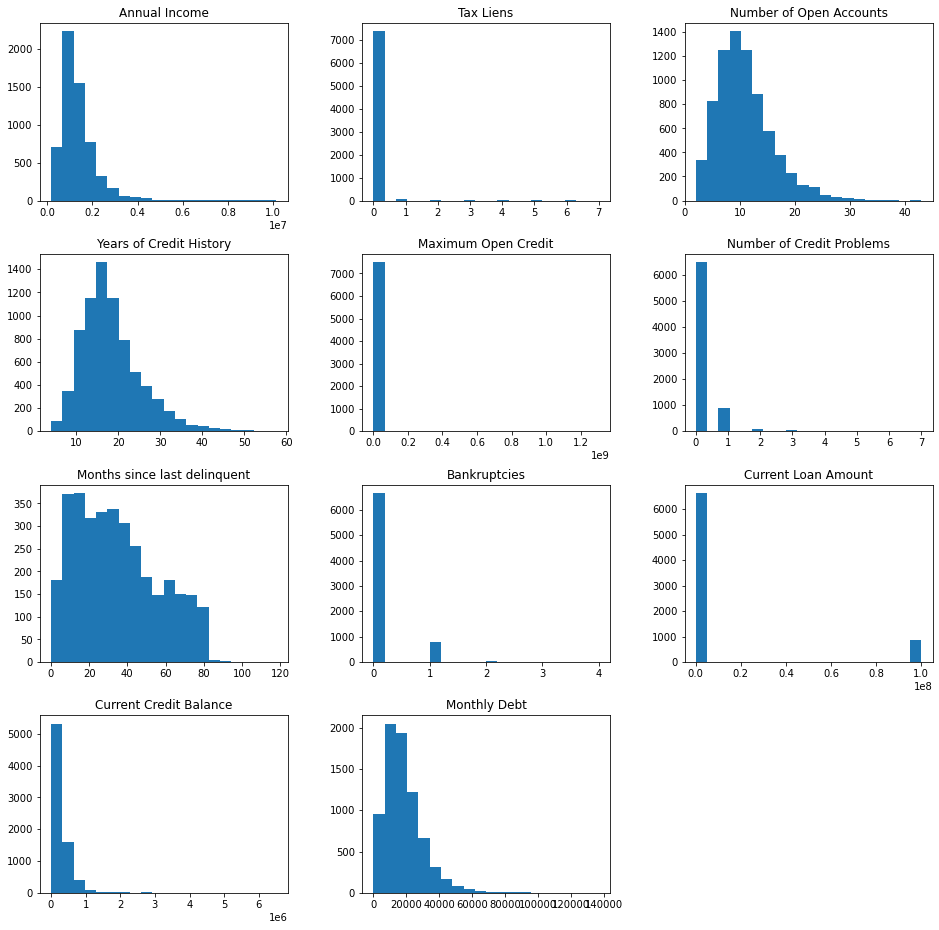

In [38]:
df_train[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

In [39]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [40]:
df_train_copy.isna().sum().sum()

7209

In [41]:
df_test_copy.isna().sum()

Annual Income                    513
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
Years_on_curr_job                  0
Home_ownership                     0
Purpose_                           0
Term_                              0
dtype: int64

In [42]:
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 1987 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   int64  
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   int64  
 6   Months since last delinquent  1142 non-null   float64
 7   Bankruptcies                  2497 non-null   float64
 8   Current Loan Amount           2500 non-null   float64
 9   Current Credit Balance        2500 non-null   float64
 10  Monthly Debt                  2500 non-null   float64
 11  Credit Score                  1987 non-null   float64
 12  Years_on_curr_job             2500 non-null   int64  
 13  Hom

In [43]:
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

#### Обработка пропусков Bankruptcies

In [44]:
feature_name = 'Bankruptcies'
#df_train_copy = preprocess_outlier(df_train_copy, feature_name, threshold=5)
#df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5)

df_train_copy[feature_name].isna().sum()

14

In [45]:
df_train_copy_ntn = df_train_copy.drop(columns=TARGET_NAME)

In [46]:
%%time
data_, target_, bankruptcies_predictor_model, pred_data_ = imputer_rfr(df_train_copy_ntn, feature_name, 0.2)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 100 to 7379
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Tax Liens                  14 non-null     float16
 1   Number of Open Accounts    14 non-null     int8   
 2   Years of Credit History    14 non-null     float16
 3   Maximum Open Credit        14 non-null     float32
 4   Number of Credit Problems  14 non-null     int8   
 5   Bankruptcies               0 non-null      float16
 6   Current Loan Amount        14 non-null     float32
 7   Current Credit Balance     14 non-null     float32
 8   Monthly Debt               14 non-null     float32
 9   Years_on_curr_job          14 non-null     int8   
 10  Home_ownership             14 non-null     int8   
 11  Purpose_                   14 non-null     int8   
 12  Term_                      14 non-null     int8   
dtypes: float16(3), float32(4), int8(6)
memory usage:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.7min finished


Grid best params:
{'bootstrap': True, 'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 200}
Evaluating best model:
Model Performance
Average Error: 0.0457 degrees.
Accuracy = -inf%.

Evaluating base model:
Model Performance
Average Error: 0.0369 degrees.
Accuracy = -inf%.
Improvement of nan%.

r2 на train: 0.9105789628561491
r2 на test: 0.7866509799097514
CPU times: user 3.38 s, sys: 564 ms, total: 3.95 s
Wall time: 2min 43s


In [47]:
df_train_copy_ntn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 5943 non-null   float32
 1   Tax Liens                     7500 non-null   float16
 2   Number of Open Accounts       7500 non-null   int8   
 3   Years of Credit History       7500 non-null   float16
 4   Maximum Open Credit           7500 non-null   float32
 5   Number of Credit Problems     7500 non-null   int8   
 6   Months since last delinquent  3419 non-null   float16
 7   Bankruptcies                  7486 non-null   float16
 8   Current Loan Amount           7500 non-null   float32
 9   Current Credit Balance        7500 non-null   float32
 10  Monthly Debt                  7500 non-null   float32
 11  Credit Score                  5943 non-null   float16
 12  Years_on_curr_job             7500 non-null   int8   
 13  Hom

In [48]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 5943 non-null   float32
 1   Tax Liens                     7500 non-null   float16
 2   Number of Open Accounts       7500 non-null   int8   
 3   Years of Credit History       7500 non-null   float16
 4   Maximum Open Credit           7500 non-null   float32
 5   Number of Credit Problems     7500 non-null   int8   
 6   Months since last delinquent  3419 non-null   float16
 7   Bankruptcies                  7486 non-null   float16
 8   Current Loan Amount           7500 non-null   float32
 9   Current Credit Balance        7500 non-null   float32
 10  Monthly Debt                  7500 non-null   float32
 11  Credit Score                  5943 non-null   float16
 12  Years_on_curr_job             7500 non-null   int8   
 13  Hom

In [49]:
pred_data_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 100 to 7379
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Tax Liens                  14 non-null     float16
 1   Number of Open Accounts    14 non-null     int8   
 2   Years of Credit History    14 non-null     float16
 3   Maximum Open Credit        14 non-null     float32
 4   Number of Credit Problems  14 non-null     int8   
 5   Bankruptcies               0 non-null      float16
 6   Current Loan Amount        14 non-null     float32
 7   Current Credit Balance     14 non-null     float32
 8   Monthly Debt               14 non-null     float32
 9   Years_on_curr_job          14 non-null     int8   
 10  Home_ownership             14 non-null     int8   
 11  Purpose_                   14 non-null     int8   
 12  Term_                      14 non-null     int8   
dtypes: float16(3), float32(4), int8(6)
memory usage:

In [50]:
pred_data_

,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Years_on_curr_job,Home_ownership,Purpose_,Term_
100,0.0,9,39.593750,644204.0,0,NaN,100000000.0,224770.0,4326.0,7,1,9,1
256,0.0,6,19.703125,291082.0,0,NaN,100000000.0,236816.0,3488.0,7,3,1,1
257,0.0,15,13.601562,1556390.0,0,NaN,447480.0,524210.0,19613.0,11,2,1,1
898,0.0,20,18.296875,2177758.0,0,NaN,456808.0,607487.0,9669.0,11,3,1,1
1404,0.0,4,12.703125,0.0,0,NaN,11242.0,0.0,1243.0,8,3,2,1
3063,0.0,5,14.898438,38126.0,0,NaN,44814.0,18373.0,929.0,2,3,2,1
3252,0.0,7,16.500000,636856.0,0,NaN,156970.0,52250.0,1145.0,8,3,7,1
3351,0.0,14,23.296875,792836.0,0,NaN,528968.0,625157.0,23746.0,3,2,1,1
3401,0.0,2,19.093750,0.0,0,NaN,100000000.0,0.0,1245.0,4,3,2,1
3496,0.0,7,11.703125,0.0,0,NaN,210166.0,0.0,0.0,7,3,9,1


In [51]:
pred_data_.loc[:, pred_data_.columns != target_].columns

Index(['Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Years_on_curr_job', 'Home_ownership', 'Purpose_', 'Term_'],
      dtype='object')

In [52]:
data_.columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Years_on_curr_job', 'Home_ownership',
       'Purpose_', 'Term_'],
      dtype='object')

In [53]:
df_train_copy = pred_rfr(data_, target_, bankruptcies_predictor_model, pred_data_)

In [54]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 5943 non-null   float32
 1   Tax Liens                     7500 non-null   float16
 2   Number of Open Accounts       7500 non-null   int8   
 3   Years of Credit History       7500 non-null   float16
 4   Maximum Open Credit           7500 non-null   float32
 5   Number of Credit Problems     7500 non-null   int8   
 6   Months since last delinquent  3419 non-null   float16
 7   Bankruptcies                  7500 non-null   float16
 8   Current Loan Amount           7500 non-null   float32
 9   Current Credit Balance        7500 non-null   float32
 10  Monthly Debt                  7500 non-null   float32
 11  Credit Score                  5943 non-null   float16
 12  Years_on_curr_job             7500 non-null   int8   
 13  Hom

In [55]:
pred_data_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 100 to 7379
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Tax Liens                  14 non-null     float16
 1   Number of Open Accounts    14 non-null     int8   
 2   Years of Credit History    14 non-null     float16
 3   Maximum Open Credit        14 non-null     float32
 4   Number of Credit Problems  14 non-null     int8   
 5   Bankruptcies               0 non-null      float16
 6   Current Loan Amount        14 non-null     float32
 7   Current Credit Balance     14 non-null     float32
 8   Monthly Debt               14 non-null     float32
 9   Years_on_curr_job          14 non-null     int8   
 10  Home_ownership             14 non-null     int8   
 11  Purpose_                   14 non-null     int8   
 12  Term_                      14 non-null     int8   
dtypes: float16(3), float32(4), int8(6)
memory usage:

In [56]:
target_

'Bankruptcies'

In [57]:
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 1987 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   int64  
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   int64  
 6   Months since last delinquent  1142 non-null   float64
 7   Bankruptcies                  2497 non-null   float64
 8   Current Loan Amount           2500 non-null   float64
 9   Current Credit Balance        2500 non-null   float64
 10  Monthly Debt                  2500 non-null   float64
 11  Credit Score                  1987 non-null   float64
 12  Years_on_curr_job             2500 non-null   int64  
 13  Hom

In [58]:
dtc = df_test_copy[df_test_copy[feature_name].isna()]
#dtc_pr = dtc.loc[:, (dtc.columns != 'Annual Income') & (dtc.columns != 'Credit Score') & (dtc.columns != 'Months since last delinquent')]
dtc_pr = dtc[pred_data_.columns]
dtc_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 241 to 801
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Tax Liens                  3 non-null      float64
 1   Number of Open Accounts    3 non-null      int64  
 2   Years of Credit History    3 non-null      float64
 3   Maximum Open Credit        3 non-null      float64
 4   Number of Credit Problems  3 non-null      int64  
 5   Bankruptcies               0 non-null      float64
 6   Current Loan Amount        3 non-null      float64
 7   Current Credit Balance     3 non-null      float64
 8   Monthly Debt               3 non-null      float64
 9   Years_on_curr_job          3 non-null      int64  
 10  Home_ownership             3 non-null      int64  
 11  Purpose_                   3 non-null      int64  
 12  Term_                      3 non-null      int64  
dtypes: float64(7), int64(6)
memory usage: 336.0 bytes


In [59]:
pred_data_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 100 to 7379
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Tax Liens                  14 non-null     float16
 1   Number of Open Accounts    14 non-null     int8   
 2   Years of Credit History    14 non-null     float16
 3   Maximum Open Credit        14 non-null     float32
 4   Number of Credit Problems  14 non-null     int8   
 5   Bankruptcies               0 non-null      float16
 6   Current Loan Amount        14 non-null     float32
 7   Current Credit Balance     14 non-null     float32
 8   Monthly Debt               14 non-null     float32
 9   Years_on_curr_job          14 non-null     int8   
 10  Home_ownership             14 non-null     int8   
 11  Purpose_                   14 non-null     int8   
 12  Term_                      14 non-null     int8   
dtypes: float16(3), float32(4), int8(6)
memory usage:

In [60]:
pred_test_ = bankruptcies_predictor_model.predict(dtc_pr.drop(columns=feature_name))
df_test_copy.loc[df_test_copy[feature_name].isna(), feature_name] = list(pred_test_)
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 1987 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   int64  
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   int64  
 6   Months since last delinquent  1142 non-null   float64
 7   Bankruptcies                  2500 non-null   float64
 8   Current Loan Amount           2500 non-null   float64
 9   Current Credit Balance        2500 non-null   float64
 10  Monthly Debt                  2500 non-null   float64
 11  Credit Score                  1987 non-null   float64
 12  Years_on_curr_job             2500 non-null   int64  
 13  Hom

#### Обработка пропусков Annual Income

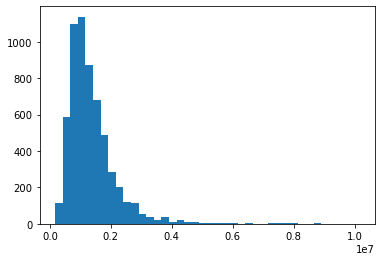

In [61]:
df_train_copy['Annual Income'].hist(bins=40, grid=False);

In [62]:
feature_name = 'Annual Income'
#df_train_copy = preprocess_outlier(df_train_copy, feature_name, threshold=2000000)
#df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=2000000)

df_train_copy[feature_name].isna().sum()

1557

In [63]:
%%time
data_, target_, annual_income_predictor, pred_data_ = imputer_rfr(df_train_copy, feature_name, 0.1)
df_train_copy = pred_rfr(data_, target_, annual_income_predictor, pred_data_)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1557 entries, 5 to 7499
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Annual Income              0 non-null      float32
 1   Tax Liens                  1557 non-null   float16
 2   Number of Open Accounts    1557 non-null   int8   
 3   Years of Credit History    1557 non-null   float16
 4   Maximum Open Credit        1557 non-null   float32
 5   Number of Credit Problems  1557 non-null   int8   
 6   Bankruptcies               1557 non-null   float16
 7   Current Loan Amount        1557 non-null   float32
 8   Current Credit Balance     1557 non-null   float32
 9   Monthly Debt               1557 non-null   float32
 10  Years_on_curr_job          1557 non-null   int8   
 11  Home_ownership             1557 non-null   int8   
 12  Purpose_                   1557 non-null   int8   
 13  Term_                      1557 non-null   int8 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.9min finished


Grid best params:
{'bootstrap': True, 'max_depth': 40, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Evaluating best model:
Model Performance
Average Error: 437965.0950 degrees.
Accuracy = 65.79%.

Evaluating base model:
Model Performance
Average Error: 466045.0094 degrees.
Accuracy = 64.17%.
Improvement of 2.53%.

r2 на train: 0.7128002845679196
r2 на test: 0.4047897029915897
CPU times: user 4.86 s, sys: 324 ms, total: 5.18 s
Wall time: 3min 53s


In [64]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   float32
 1   Tax Liens                     7500 non-null   float16
 2   Number of Open Accounts       7500 non-null   int8   
 3   Years of Credit History       7500 non-null   float16
 4   Maximum Open Credit           7500 non-null   float32
 5   Number of Credit Problems     7500 non-null   int8   
 6   Months since last delinquent  3419 non-null   float16
 7   Bankruptcies                  7500 non-null   float16
 8   Current Loan Amount           7500 non-null   float32
 9   Current Credit Balance        7500 non-null   float32
 10  Monthly Debt                  7500 non-null   float32
 11  Credit Score                  5943 non-null   float16
 12  Years_on_curr_job             7500 non-null   int8   
 13  Hom

In [65]:
dtc = df_test_copy[df_test_copy[feature_name].isna()]
dtc_pr = dtc[pred_data_.columns]
dtc_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513 entries, 0 to 2496
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Annual Income              0 non-null      float64
 1   Tax Liens                  513 non-null    float64
 2   Number of Open Accounts    513 non-null    int64  
 3   Years of Credit History    513 non-null    float64
 4   Maximum Open Credit        513 non-null    float64
 5   Number of Credit Problems  513 non-null    int64  
 6   Bankruptcies               513 non-null    float64
 7   Current Loan Amount        513 non-null    float64
 8   Current Credit Balance     513 non-null    float64
 9   Monthly Debt               513 non-null    float64
 10  Years_on_curr_job          513 non-null    int64  
 11  Home_ownership             513 non-null    int64  
 12  Purpose_                   513 non-null    int64  
 13  Term_                      513 non-null    int64 

In [66]:
pred_test_ = annual_income_predictor.predict(dtc_pr.drop(columns=feature_name))
df_test_copy.loc[df_test_copy[feature_name].isna(), feature_name] = list(pred_test_)
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   int64  
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   int64  
 6   Months since last delinquent  1142 non-null   float64
 7   Bankruptcies                  2500 non-null   float64
 8   Current Loan Amount           2500 non-null   float64
 9   Current Credit Balance        2500 non-null   float64
 10  Monthly Debt                  2500 non-null   float64
 11  Credit Score                  1987 non-null   float64
 12  Years_on_curr_job             2500 non-null   int64  
 13  Hom

#### Обработка пропусков Credit Score

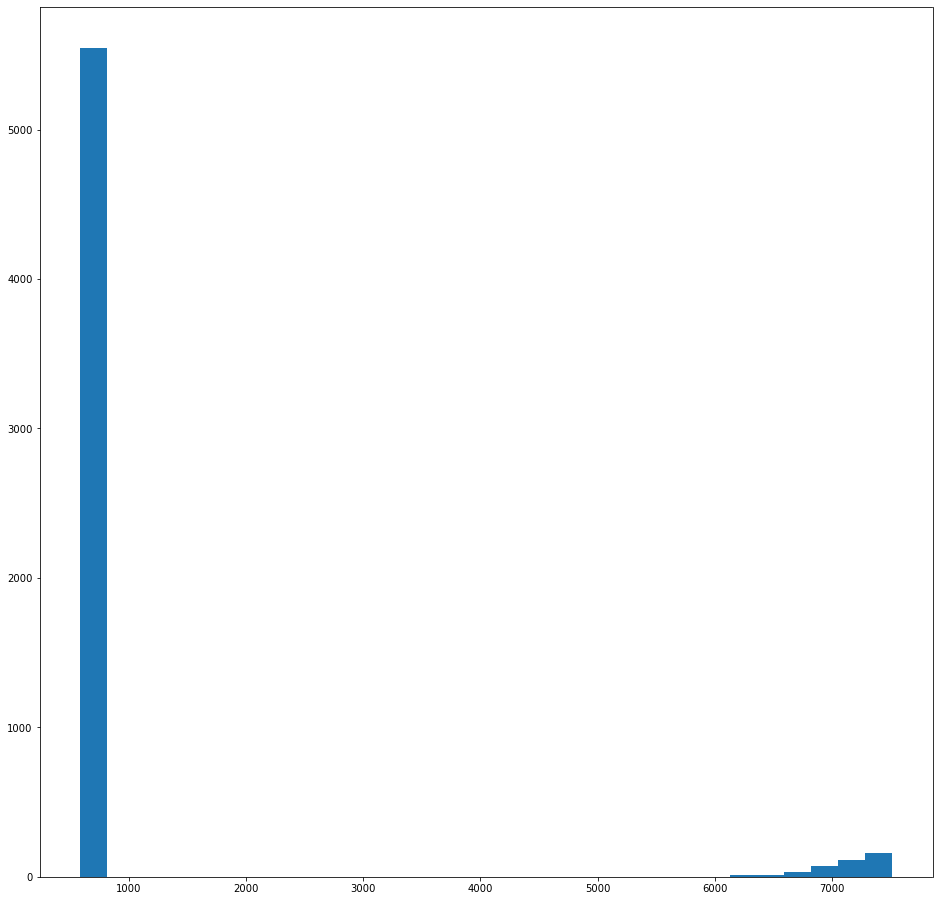

In [67]:
df_train_copy['Credit Score'].hist(figsize=(16, 16), bins=30, grid=False);

In [68]:
feature_name = 'Credit Score'
#df_train_copy = preprocess_outlier(df_train_copy, feature_name, threshold=2000000)
#df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=2000000)

df_train_copy[feature_name].isna().sum()

1557

In [69]:
%%time
data_, target_, credit_score_predictor, pred_data_ = imputer_rfr(df_train_copy, feature_name, 0.2)
df_train_copy = pred_rfr(data_, target_, credit_score_predictor, pred_data_)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1557 entries, 5 to 7499
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Annual Income              1557 non-null   float32
 1   Tax Liens                  1557 non-null   float16
 2   Number of Open Accounts    1557 non-null   int8   
 3   Years of Credit History    1557 non-null   float16
 4   Maximum Open Credit        1557 non-null   float32
 5   Number of Credit Problems  1557 non-null   int8   
 6   Bankruptcies               1557 non-null   float16
 7   Current Loan Amount        1557 non-null   float32
 8   Current Credit Balance     1557 non-null   float32
 9   Monthly Debt               1557 non-null   float32
 10  Credit Score               0 non-null      float16
 11  Years_on_curr_job          1557 non-null   int8   
 12  Home_ownership             1557 non-null   int8   
 13  Purpose_                   1557 non-null   int8 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.3min finished


Grid best params:
{'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}
Evaluating best model:
Model Performance
Average Error: 777.2064 degrees.
Accuracy = 37.70%.

Evaluating base model:
Model Performance
Average Error: 830.3511 degrees.
Accuracy = 29.14%.
Improvement of 29.35%.

r2 на train: 1.0
r2 на test: 1.0
CPU times: user 3.14 s, sys: 280 ms, total: 3.42 s
Wall time: 3min 16s


In [70]:
dtc = df_test_copy[df_test_copy[feature_name].isna()]
dtc_pr = dtc[pred_data_.columns]
dtc_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513 entries, 0 to 2496
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Annual Income              513 non-null    float64
 1   Tax Liens                  513 non-null    float64
 2   Number of Open Accounts    513 non-null    int64  
 3   Years of Credit History    513 non-null    float64
 4   Maximum Open Credit        513 non-null    float64
 5   Number of Credit Problems  513 non-null    int64  
 6   Bankruptcies               513 non-null    float64
 7   Current Loan Amount        513 non-null    float64
 8   Current Credit Balance     513 non-null    float64
 9   Monthly Debt               513 non-null    float64
 10  Credit Score               0 non-null      float64
 11  Years_on_curr_job          513 non-null    int64  
 12  Home_ownership             513 non-null    int64  
 13  Purpose_                   513 non-null    int64 

In [71]:
pred_test_ = credit_score_predictor.predict(dtc_pr.drop(columns=feature_name))
df_test_copy.loc[df_test_copy[feature_name].isna(), feature_name] = list(pred_test_)
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   int64  
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   int64  
 6   Months since last delinquent  1142 non-null   float64
 7   Bankruptcies                  2500 non-null   float64
 8   Current Loan Amount           2500 non-null   float64
 9   Current Credit Balance        2500 non-null   float64
 10  Monthly Debt                  2500 non-null   float64
 11  Credit Score                  2500 non-null   float64
 12  Years_on_curr_job             2500 non-null   int64  
 13  Hom

#### Обработка пропусков Months since last delinquent

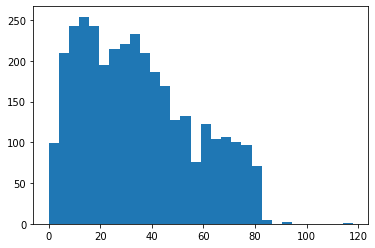

In [72]:
feature_name = 'Months since last delinquent'

df_train_copy[feature_name].hist(bins=30, grid=False);

In [73]:
df_train_copy = preprocess_outlier(df_train_copy, feature_name, threshold=95)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=95)

df_train_copy[feature_name].isna().sum()

4082

In [74]:
%%time
data_, target_, months_since_last_delinquent_predictor, pred_data_ = imputer_rfr(df_train_copy, feature_name, 0.2)
df_train_copy = pred_rfr(data_, target_, months_since_last_delinquent_predictor, pred_data_)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4082 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 4082 non-null   float32
 1   Tax Liens                     4082 non-null   float16
 2   Number of Open Accounts       4082 non-null   int8   
 3   Years of Credit History       4082 non-null   float16
 4   Maximum Open Credit           4082 non-null   float32
 5   Number of Credit Problems     4082 non-null   int8   
 6   Months since last delinquent  0 non-null      float16
 7   Bankruptcies                  4082 non-null   float16
 8   Current Loan Amount           4082 non-null   float32
 9   Current Credit Balance        4082 non-null   float32
 10  Monthly Debt                  4082 non-null   float32
 11  Credit Score                  4082 non-null   float16
 12  Years_on_curr_job             4082 non-null   int8   
 13  Hom

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.2min finished


Grid best params:
{'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 400}
Evaluating best model:
Model Performance
Average Error: 17.4728 degrees.
Accuracy = -inf%.

Evaluating base model:
Model Performance
Average Error: 18.3956 degrees.
Accuracy = -inf%.
Improvement of nan%.

r2 на train: 0.26138889402815535
r2 на test: 0.0275947967974719
CPU times: user 3.79 s, sys: 370 ms, total: 4.16 s
Wall time: 2min 11s


In [75]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   float32
 1   Tax Liens                     7500 non-null   float16
 2   Number of Open Accounts       7500 non-null   int8   
 3   Years of Credit History       7500 non-null   float16
 4   Maximum Open Credit           7500 non-null   float32
 5   Number of Credit Problems     7500 non-null   int8   
 6   Months since last delinquent  7500 non-null   float16
 7   Bankruptcies                  7500 non-null   float16
 8   Current Loan Amount           7500 non-null   float32
 9   Current Credit Balance        7500 non-null   float32
 10  Monthly Debt                  7500 non-null   float32
 11  Credit Score                  7500 non-null   float16
 12  Years_on_curr_job             7500 non-null   int8   
 13  Hom

In [76]:
dtc = df_test_copy[df_test_copy[feature_name].isna()]
dtc_pr = dtc[pred_data_.columns]
dtc_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1358 entries, 2 to 2498
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 1358 non-null   float64
 1   Tax Liens                     1358 non-null   float64
 2   Number of Open Accounts       1358 non-null   int64  
 3   Years of Credit History       1358 non-null   float64
 4   Maximum Open Credit           1358 non-null   float64
 5   Number of Credit Problems     1358 non-null   int64  
 6   Months since last delinquent  0 non-null      float64
 7   Bankruptcies                  1358 non-null   float64
 8   Current Loan Amount           1358 non-null   float64
 9   Current Credit Balance        1358 non-null   float64
 10  Monthly Debt                  1358 non-null   float64
 11  Credit Score                  1358 non-null   float64
 12  Years_on_curr_job             1358 non-null   int64  
 13  Hom

In [77]:
pred_test_ = months_since_last_delinquent_predictor.predict(dtc_pr.drop(columns=feature_name))
df_test_copy.loc[df_test_copy[feature_name].isna(), feature_name] = list(pred_test_)
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   int64  
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   int64  
 6   Months since last delinquent  2500 non-null   float64
 7   Bankruptcies                  2500 non-null   float64
 8   Current Loan Amount           2500 non-null   float64
 9   Current Credit Balance        2500 non-null   float64
 10  Monthly Debt                  2500 non-null   float64
 11  Credit Score                  2500 non-null   float64
 12  Years_on_curr_job             2500 non-null   int64  
 13  Hom

### Балансировка по целевой переменной

In [78]:
#df_train_copy[TARGET_NAME].value_counts()
y_train.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [79]:
df_for_balancing = pd.concat([df_train_copy.loc[:, df_train_copy.columns != TARGET_NAME], y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
df_balanced[TARGET_NAME].value_counts()

1    5387
0    5387
Name: Credit Default, dtype: int64

In [80]:
df_for_balancing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   float32
 1   Tax Liens                     7500 non-null   float16
 2   Number of Open Accounts       7500 non-null   int8   
 3   Years of Credit History       7500 non-null   float16
 4   Maximum Open Credit           7500 non-null   float32
 5   Number of Credit Problems     7500 non-null   int8   
 6   Months since last delinquent  7500 non-null   float16
 7   Bankruptcies                  7500 non-null   float16
 8   Current Loan Amount           7500 non-null   float32
 9   Current Credit Balance        7500 non-null   float32
 10  Monthly Debt                  7500 non-null   float32
 11  Credit Score                  7500 non-null   float16
 12  Years_on_curr_job             7500 non-null   int8   
 13  Hom

In [81]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [82]:
X_train_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10774 entries, 7912 to 1146
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 10774 non-null  float32
 1   Tax Liens                     10774 non-null  float16
 2   Number of Open Accounts       10774 non-null  int8   
 3   Years of Credit History       10774 non-null  float16
 4   Maximum Open Credit           10774 non-null  float32
 5   Number of Credit Problems     10774 non-null  int8   
 6   Months since last delinquent  10774 non-null  float16
 7   Bankruptcies                  10774 non-null  float16
 8   Current Loan Amount           10774 non-null  float32
 9   Current Credit Balance        10774 non-null  float32
 10  Monthly Debt                  10774 non-null  float32
 11  Credit Score                  10774 non-null  float16
 12  Years_on_curr_job             10774 non-null  int8   
 13 

In [83]:
len(y_train_balanced)

10774

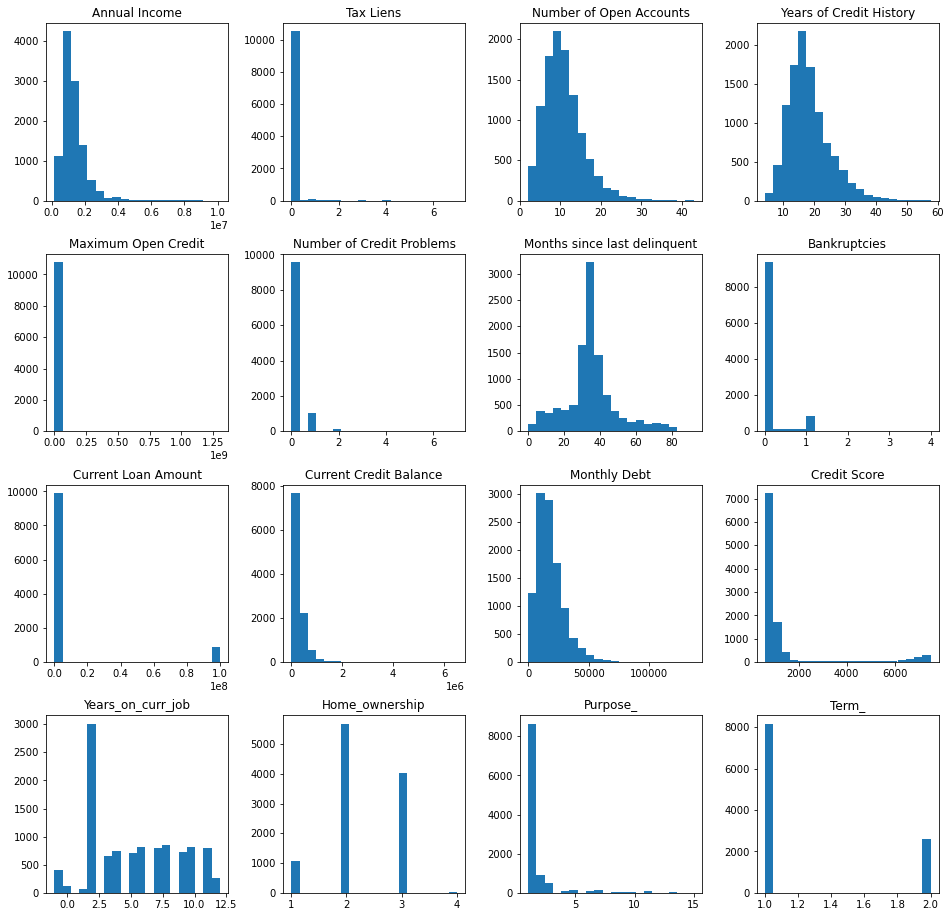

In [84]:
X_train_balanced.hist(figsize=(16, 16), bins=20, grid=False);

#### Обработка выбросов Maximum Open Credit

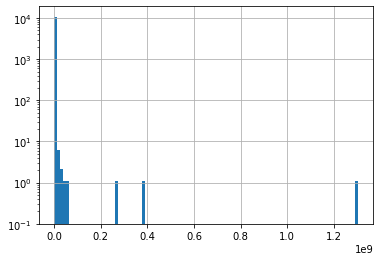

In [85]:
log_hist_plot(X_train_balanced['Maximum Open Credit'], bins=100)

In [86]:
X_train_balanced['Maximum Open Credit'].loc[X_train_balanced['Maximum Open Credit'] > 5000000].describe()

count    5.900000e+01
mean     4.310952e+07
std      1.770684e+08
min      5.109676e+06
25%      6.123738e+06
50%      7.204516e+06
75%      1.155866e+07
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [87]:
len(X_train_balanced['Maximum Open Credit'].loc[X_train_balanced['Maximum Open Credit'] > 5000000])

59

In [88]:
X_train_bal_copy = X_train_balanced.copy()
feature_name = 'Maximum Open Credit'
X_train_bal_copy = preprocess_outlier(X_train_bal_copy, feature_name, threshold=5000000)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5000000)

X_train_bal_copy[feature_name].describe()

count    1.071500e+04
mean     5.994513e+05
std      5.053679e+05
min      0.000000e+00
25%      2.693923e+05
50%      4.647060e+05
75%      7.678348e+05
max      4.860504e+06
Name: Maximum Open Credit, dtype: float64

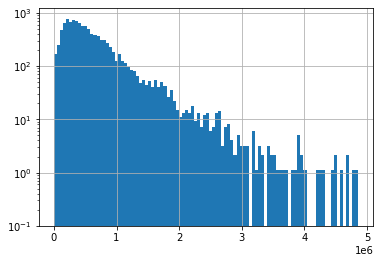

In [89]:
log_hist_plot(X_train_bal_copy['Maximum Open Credit'], bins=100)

In [90]:
X_train_bal_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10774 entries, 7912 to 1146
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 10774 non-null  float32
 1   Tax Liens                     10774 non-null  float16
 2   Number of Open Accounts       10774 non-null  int8   
 3   Years of Credit History       10774 non-null  float16
 4   Maximum Open Credit           10715 non-null  float32
 5   Number of Credit Problems     10774 non-null  int8   
 6   Months since last delinquent  10774 non-null  float16
 7   Bankruptcies                  10774 non-null  float16
 8   Current Loan Amount           10774 non-null  float32
 9   Current Credit Balance        10774 non-null  float32
 10  Monthly Debt                  10774 non-null  float32
 11  Credit Score                  10774 non-null  float16
 12  Years_on_curr_job             10774 non-null  int8   
 13 

In [91]:
%%time
data_, target_, maximum_open_score_predictor, pred_data_ = imputer_rfr(X_train_bal_copy, feature_name, 0.2)
X_train_bal_copy = pred_rfr(data_, target_, maximum_open_score_predictor, pred_data_)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 4912 to 1690
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 59 non-null     float32
 1   Tax Liens                     59 non-null     float16
 2   Number of Open Accounts       59 non-null     int8   
 3   Years of Credit History       59 non-null     float16
 4   Maximum Open Credit           0 non-null      float32
 5   Number of Credit Problems     59 non-null     int8   
 6   Months since last delinquent  59 non-null     float16
 7   Bankruptcies                  59 non-null     float16
 8   Current Loan Amount           59 non-null     float32
 9   Current Credit Balance        59 non-null     float32
 10  Monthly Debt                  59 non-null     float32
 11  Credit Score                  59 non-null     float16
 12  Years_on_curr_job             59 non-null     int8   
 13  Ho

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  5.0min finished


Grid best params:
{'bootstrap': True, 'max_depth': 40, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 200}
Evaluating best model:
Model Performance
Average Error: 168099.8225 degrees.
Accuracy = -inf%.

Evaluating base model:
Model Performance
Average Error: 167558.6888 degrees.
Accuracy = -inf%.
Improvement of nan%.

r2 на train: 0.889228137690276
r2 на test: 0.7188596705441987
CPU times: user 5.58 s, sys: 337 ms, total: 5.92 s
Wall time: 5min


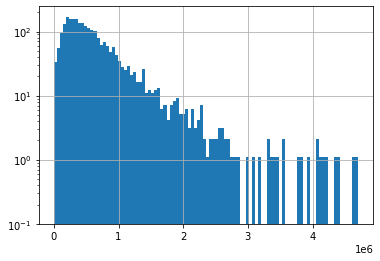

In [92]:
log_hist_plot(df_test_copy['Maximum Open Credit'], bins=100)

In [93]:
dtc = df_test_copy[df_test_copy[feature_name].isna()]
dtc_pr = dtc[pred_data_.columns]
dtc_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 176 to 2247
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 17 non-null     float64
 1   Tax Liens                     17 non-null     float64
 2   Number of Open Accounts       17 non-null     int64  
 3   Years of Credit History       17 non-null     float64
 4   Maximum Open Credit           0 non-null      float64
 5   Number of Credit Problems     17 non-null     int64  
 6   Months since last delinquent  17 non-null     float64
 7   Bankruptcies                  17 non-null     float64
 8   Current Loan Amount           17 non-null     float64
 9   Current Credit Balance        17 non-null     float64
 10  Monthly Debt                  17 non-null     float64
 11  Credit Score                  17 non-null     float64
 12  Years_on_curr_job             17 non-null     int64  
 13  Hom

In [94]:
pred_test_ = maximum_open_score_predictor.predict(dtc_pr.drop(columns=feature_name))
df_test_copy.loc[df_test_copy[feature_name].isna(), feature_name] = list(pred_test_)
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   int64  
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   int64  
 6   Months since last delinquent  2500 non-null   float64
 7   Bankruptcies                  2500 non-null   float64
 8   Current Loan Amount           2500 non-null   float64
 9   Current Credit Balance        2500 non-null   float64
 10  Monthly Debt                  2500 non-null   float64
 11  Credit Score                  2500 non-null   float64
 12  Years_on_curr_job             2500 non-null   int64  
 13  Hom

#### Обработка выбросов Tax Liens

In [95]:
feature_name = 'Tax Liens'

In [96]:
X_train_bal_copy[feature_name].loc[X_train_bal_copy[feature_name] > 2].describe()

count    28.000000
mean      3.681641
std       1.153320
min       2.154297
25%       3.000000
50%       3.000977
75%       4.000000
max       7.000000
Name: Tax Liens, dtype: float64

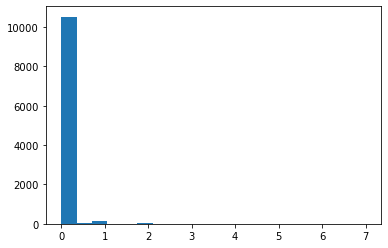

In [97]:
X_train_bal_copy[feature_name].hist(bins=20, grid=False);

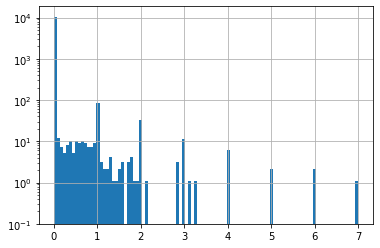

In [98]:
log_hist_plot(X_train_bal_copy[feature_name], bins=100)

In [99]:
X_train_bal_copy = X_train_bal_copy.copy()
X_train_bal_copy = preprocess_outlier(X_train_bal_copy, feature_name, threshold=2)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=2)

X_train_bal_copy[feature_name].describe()

count    10746.000000
mean         0.023132
std          0.169678
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: Tax Liens, dtype: float64

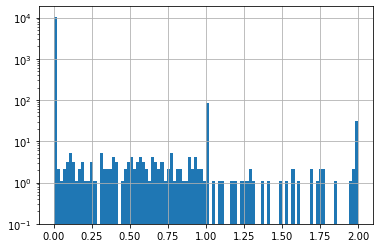

In [100]:
log_hist_plot(X_train_bal_copy[feature_name], bins=100)

In [101]:
%%time
data_, target_, tax_liens_predictor, pred_data_ = imputer_rfr(X_train_bal_copy, feature_name, 0.2)
X_train_bal_copy = pred_rfr(data_, target_, tax_liens_predictor, pred_data_)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 4990 to 39
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 28 non-null     float32
 1   Tax Liens                     0 non-null      float16
 2   Number of Open Accounts       28 non-null     int8   
 3   Years of Credit History       28 non-null     float16
 4   Maximum Open Credit           28 non-null     float32
 5   Number of Credit Problems     28 non-null     int8   
 6   Months since last delinquent  28 non-null     float16
 7   Bankruptcies                  28 non-null     float16
 8   Current Loan Amount           28 non-null     float32
 9   Current Credit Balance        28 non-null     float32
 10  Monthly Debt                  28 non-null     float32
 11  Credit Score                  28 non-null     float16
 12  Years_on_curr_job             28 non-null     int8   
 13  Home

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  4.3min finished


Grid best params:
{'bootstrap': True, 'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 400}
Evaluating best model:
Model Performance
Average Error: 0.0344 degrees.
Accuracy = -inf%.

Evaluating base model:
Model Performance
Average Error: 0.0285 degrees.
Accuracy = -inf%.
Improvement of nan%.

r2 на train: 0.8026180930553775
r2 на test: 0.47686943980549656
CPU times: user 6.5 s, sys: 247 ms, total: 6.75 s
Wall time: 4min 19s


In [102]:
X_train_bal_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10774 entries, 7912 to 1146
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 10774 non-null  float32
 1   Tax Liens                     10774 non-null  float16
 2   Number of Open Accounts       10774 non-null  int8   
 3   Years of Credit History       10774 non-null  float16
 4   Maximum Open Credit           10774 non-null  float32
 5   Number of Credit Problems     10774 non-null  int8   
 6   Months since last delinquent  10774 non-null  float16
 7   Bankruptcies                  10774 non-null  float16
 8   Current Loan Amount           10774 non-null  float32
 9   Current Credit Balance        10774 non-null  float32
 10  Monthly Debt                  10774 non-null  float32
 11  Credit Score                  10774 non-null  float16
 12  Years_on_curr_job             10774 non-null  int8   
 13 

In [103]:
X_train_bal_copy.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Years_on_curr_job,Home_ownership,Purpose_,Term_
7912,1394769.000,0.0,7,19.09375,665966.937500,0,34.781250,0.0,479058.15625,548503.437500,23857.791016,689.0,9,2,1,1
2500,1247597.000,0.0,12,17.00000,937772.000000,0,69.000000,0.0,485606.00000,506996.000000,22665.000000,693.0,4,2,1,2
7794,696113.625,0.0,8,19.15625,259403.390625,0,17.703125,0.0,316130.21875,133677.921875,15189.490234,6748.0,3,2,1,1
3046,1150963.000,0.0,5,18.59375,328350.000000,0,34.156250,0.0,562496.00000,234802.000000,18386.000000,707.0,2,3,1,2
2635,768360.000,0.0,6,11.00000,315722.000000,0,38.312500,0.0,213532.00000,179417.000000,4604.000000,718.0,7,2,1,1


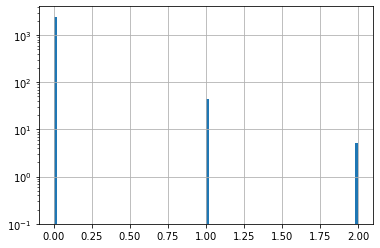

In [104]:
log_hist_plot(df_test_copy[feature_name], bins=100)

In [105]:
dtc = df_test_copy[df_test_copy[feature_name].isna()]
dtc_pr = dtc[pred_data_.columns]
dtc_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 455 to 2282
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 5 non-null      float64
 1   Tax Liens                     0 non-null      float64
 2   Number of Open Accounts       5 non-null      int64  
 3   Years of Credit History       5 non-null      float64
 4   Maximum Open Credit           5 non-null      float64
 5   Number of Credit Problems     5 non-null      int64  
 6   Months since last delinquent  5 non-null      float64
 7   Bankruptcies                  5 non-null      float64
 8   Current Loan Amount           5 non-null      float64
 9   Current Credit Balance        5 non-null      float64
 10  Monthly Debt                  5 non-null      float64
 11  Credit Score                  5 non-null      float64
 12  Years_on_curr_job             5 non-null      int64  
 13  Home

In [106]:
pred_test_ = maximum_open_score_predictor.predict(dtc_pr.drop(columns=feature_name))
df_test_copy.loc[df_test_copy[feature_name].isna(), feature_name] = list(pred_test_)
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   int64  
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   int64  
 6   Months since last delinquent  2500 non-null   float64
 7   Bankruptcies                  2500 non-null   float64
 8   Current Loan Amount           2500 non-null   float64
 9   Current Credit Balance        2500 non-null   float64
 10  Monthly Debt                  2500 non-null   float64
 11  Credit Score                  2500 non-null   float64
 12  Years_on_curr_job             2500 non-null   int64  
 13  Hom

#### Обработка выбросов Current Loan Amount

In [107]:
feature_name = 'Current Loan Amount'

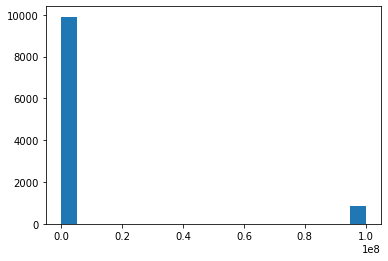

In [108]:
X_train_bal_copy[feature_name].hist(bins=20, grid=False);

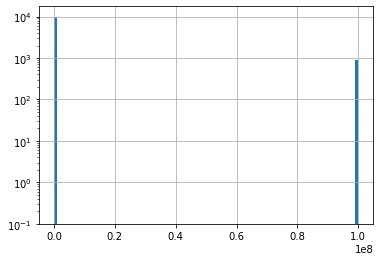

In [109]:
log_hist_plot(X_train_bal_copy[feature_name], bins=100)

In [110]:
X_train_bal_copy[feature_name].describe()

count    1.077400e+04
mean     8.364672e+06
std      2.716097e+07
min      1.124200e+04
25%      1.826843e+05
50%      3.014632e+05
75%      4.816561e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [111]:
X_train_bal_copy[feature_name].loc[X_train_bal_copy[feature_name] > 800000].describe()

count    8.700000e+02
mean     9.999976e+07
std      2.401380e+02
min      1.000000e+08
25%      1.000000e+08
50%      1.000000e+08
75%      1.000000e+08
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [112]:
X_train_bal_copy = X_train_bal_copy.copy()
X_train_bal_copy = preprocess_outlier(X_train_bal_copy, feature_name, threshold=800000)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=800000)

X_train_bal_copy[feature_name].describe()

count      9904.000000
mean     315159.625000
std      181863.296875
min       11242.000000
25%      176656.796875
50%      269716.125000
75%      433961.000000
max      789030.000000
Name: Current Loan Amount, dtype: float64

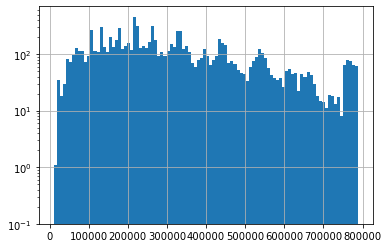

In [113]:
log_hist_plot(X_train_bal_copy[feature_name], bins=100)

In [114]:
%%time
data_, target_, current_loan_amount_predictor, pred_data_ = imputer_rfr(X_train_bal_copy, feature_name, 0.2)
X_train_bal_copy = pred_rfr(data_, target_, current_loan_amount_predictor, pred_data_)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 870 entries, 1906 to 100
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 870 non-null    float32
 1   Tax Liens                     870 non-null    float16
 2   Number of Open Accounts       870 non-null    int8   
 3   Years of Credit History       870 non-null    float16
 4   Maximum Open Credit           870 non-null    float32
 5   Number of Credit Problems     870 non-null    int8   
 6   Months since last delinquent  870 non-null    float16
 7   Bankruptcies                  870 non-null    float16
 8   Current Loan Amount           0 non-null      float32
 9   Current Credit Balance        870 non-null    float32
 10  Monthly Debt                  870 non-null    float32
 11  Credit Score                  870 non-null    float16
 12  Years_on_curr_job             870 non-null    int8   
 13  Ho

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  4.5min finished


Grid best params:
{'bootstrap': True, 'max_depth': 30, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 300}
Evaluating best model:
Model Performance
Average Error: 84860.5092 degrees.
Accuracy = 57.08%.

Evaluating base model:
Model Performance
Average Error: 85055.4066 degrees.
Accuracy = 58.52%.
Improvement of -2.45%.

r2 на train: 0.866503926995678
r2 на test: 0.6020826135036021
CPU times: user 6.29 s, sys: 345 ms, total: 6.64 s
Wall time: 4min 32s


In [115]:
X_train_bal_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10774 entries, 7912 to 1146
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 10774 non-null  float32
 1   Tax Liens                     10774 non-null  float16
 2   Number of Open Accounts       10774 non-null  int8   
 3   Years of Credit History       10774 non-null  float16
 4   Maximum Open Credit           10774 non-null  float32
 5   Number of Credit Problems     10774 non-null  int8   
 6   Months since last delinquent  10774 non-null  float16
 7   Bankruptcies                  10774 non-null  float16
 8   Current Loan Amount           10774 non-null  float32
 9   Current Credit Balance        10774 non-null  float32
 10  Monthly Debt                  10774 non-null  float32
 11  Credit Score                  10774 non-null  float16
 12  Years_on_curr_job             10774 non-null  int8   
 13 

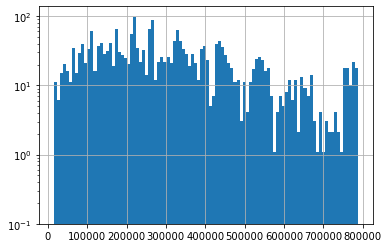

In [116]:
log_hist_plot(df_test_copy[feature_name], bins=100)

In [117]:
dtc = df_test_copy[df_test_copy[feature_name].isna()]
dtc_pr = dtc[pred_data_.columns]
dtc_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 17 to 2495
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 297 non-null    float64
 1   Tax Liens                     297 non-null    float64
 2   Number of Open Accounts       297 non-null    int64  
 3   Years of Credit History       297 non-null    float64
 4   Maximum Open Credit           297 non-null    float64
 5   Number of Credit Problems     297 non-null    int64  
 6   Months since last delinquent  297 non-null    float64
 7   Bankruptcies                  297 non-null    float64
 8   Current Loan Amount           0 non-null      float64
 9   Current Credit Balance        297 non-null    float64
 10  Monthly Debt                  297 non-null    float64
 11  Credit Score                  297 non-null    float64
 12  Years_on_curr_job             297 non-null    int64  
 13  Hom

In [118]:
pred_test_ = maximum_open_score_predictor.predict(dtc_pr.drop(columns=feature_name))
df_test_copy.loc[df_test_copy[feature_name].isna(), feature_name] = list(pred_test_)
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   int64  
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   int64  
 6   Months since last delinquent  2500 non-null   float64
 7   Bankruptcies                  2500 non-null   float64
 8   Current Loan Amount           2500 non-null   float64
 9   Current Credit Balance        2500 non-null   float64
 10  Monthly Debt                  2500 non-null   float64
 11  Credit Score                  2500 non-null   float64
 12  Years_on_curr_job             2500 non-null   int64  
 13  Hom

#### Обработка выбросов Current Credit Balance

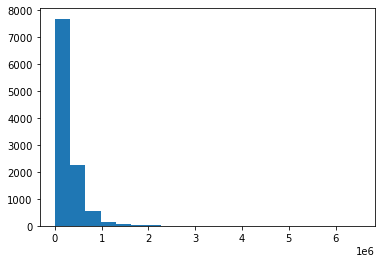

In [119]:
feature_name = 'Current Credit Balance'
X_train_bal_copy[feature_name].hist(bins=20, grid=False);

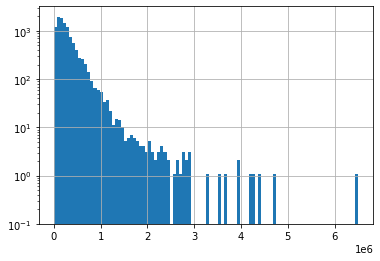

In [120]:
log_hist_plot(X_train_bal_copy[feature_name], bins=100)

In [121]:
X_train_bal_copy[feature_name].describe()

count    1.077400e+04
mean     2.856467e+05
std      2.978728e+05
min      0.000000e+00
25%      1.148598e+05
50%      2.088290e+05
75%      3.550910e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

In [122]:
X_train_bal_copy[feature_name].loc[X_train_bal_copy[feature_name] > 500000].describe()

count    1.502000e+03
mean     8.191607e+05
std      4.629591e+05
min      5.002320e+05
25%      5.801574e+05
50%      6.749117e+05
75%      8.704328e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

In [123]:
X_train_bal_copy = X_train_bal_copy.copy()
X_train_bal_copy = preprocess_outlier(X_train_bal_copy, feature_name, threshold=500000)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=500000)

X_train_bal_copy[feature_name].describe()

count      9272.000000
mean     199221.468750
std      121729.250000
min           0.000000
25%      103756.484375
50%      180414.812500
75%      284895.500000
max      499852.000000
Name: Current Credit Balance, dtype: float64

In [124]:
%%time
data_, target_, current_credit_balance_predictor, pred_data_ = imputer_rfr(X_train_bal_copy, feature_name, 0.2)
X_train_bal_copy = pred_rfr(data_, target_, current_credit_balance_predictor, pred_data_)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1502 entries, 7912 to 4566
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 1502 non-null   float32
 1   Tax Liens                     1502 non-null   float16
 2   Number of Open Accounts       1502 non-null   int8   
 3   Years of Credit History       1502 non-null   float16
 4   Maximum Open Credit           1502 non-null   float32
 5   Number of Credit Problems     1502 non-null   int8   
 6   Months since last delinquent  1502 non-null   float16
 7   Bankruptcies                  1502 non-null   float16
 8   Current Loan Amount           1502 non-null   float32
 9   Current Credit Balance        0 non-null      float32
 10  Monthly Debt                  1502 non-null   float32
 11  Credit Score                  1502 non-null   float16
 12  Years_on_curr_job             1502 non-null   int8   
 13  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  4.2min finished


Grid best params:
{'bootstrap': True, 'max_depth': 40, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 400}
Evaluating best model:
Model Performance
Average Error: 48243.1615 degrees.
Accuracy = -inf%.

Evaluating base model:
Model Performance
Average Error: 48103.5879 degrees.
Accuracy = -inf%.
Improvement of nan%.

r2 на train: 0.8915710449000475
r2 на test: 0.7100518836323072
CPU times: user 7.06 s, sys: 350 ms, total: 7.41 s
Wall time: 4min 19s


In [125]:
X_train_bal_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10774 entries, 7912 to 1146
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 10774 non-null  float32
 1   Tax Liens                     10774 non-null  float16
 2   Number of Open Accounts       10774 non-null  int8   
 3   Years of Credit History       10774 non-null  float16
 4   Maximum Open Credit           10774 non-null  float32
 5   Number of Credit Problems     10774 non-null  int8   
 6   Months since last delinquent  10774 non-null  float16
 7   Bankruptcies                  10774 non-null  float16
 8   Current Loan Amount           10774 non-null  float32
 9   Current Credit Balance        10774 non-null  float32
 10  Monthly Debt                  10774 non-null  float32
 11  Credit Score                  10774 non-null  float16
 12  Years_on_curr_job             10774 non-null  int8   
 13 

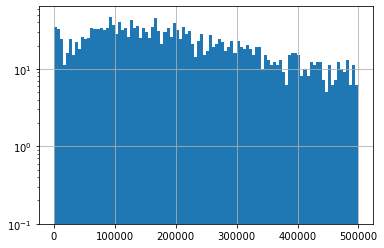

In [126]:
log_hist_plot(df_test_copy[feature_name], bins=100)

In [127]:
dtc = df_test_copy[df_test_copy[feature_name].isna()]
dtc_pr = dtc[pred_data_.columns]
dtc_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 15 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 351 non-null    float64
 1   Tax Liens                     351 non-null    float64
 2   Number of Open Accounts       351 non-null    int64  
 3   Years of Credit History       351 non-null    float64
 4   Maximum Open Credit           351 non-null    float64
 5   Number of Credit Problems     351 non-null    int64  
 6   Months since last delinquent  351 non-null    float64
 7   Bankruptcies                  351 non-null    float64
 8   Current Loan Amount           351 non-null    float64
 9   Current Credit Balance        0 non-null      float64
 10  Monthly Debt                  351 non-null    float64
 11  Credit Score                  351 non-null    float64
 12  Years_on_curr_job             351 non-null    int64  
 13  Hom

In [128]:
pred_test_ = maximum_open_score_predictor.predict(dtc_pr.drop(columns=feature_name))
df_test_copy.loc[df_test_copy[feature_name].isna(), feature_name] = list(pred_test_)
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   int64  
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   int64  
 6   Months since last delinquent  2500 non-null   float64
 7   Bankruptcies                  2500 non-null   float64
 8   Current Loan Amount           2500 non-null   float64
 9   Current Credit Balance        2500 non-null   float64
 10  Monthly Debt                  2500 non-null   float64
 11  Credit Score                  2500 non-null   float64
 12  Years_on_curr_job             2500 non-null   int64  
 13  Hom

#### Проверим Monthly Debt

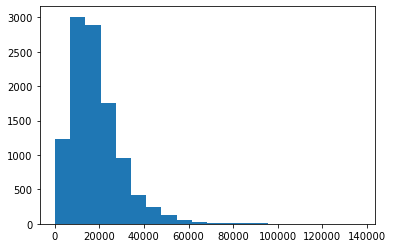

In [129]:
feature_name = 'Monthly Debt'
X_train_bal_copy[feature_name].hist(bins=20, grid=False);

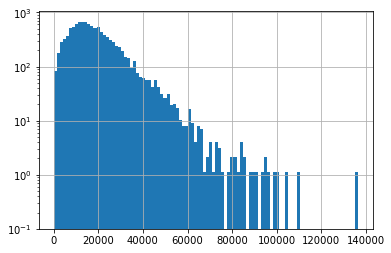

In [130]:
log_hist_plot(X_train_bal_copy[feature_name], bins=100)

In [131]:
X_train_bal_copy[feature_name].describe()

count     10774.000000
mean      18373.568359
std       11582.638672
min           0.000000
25%       10461.000000
50%       16135.292480
75%       23718.250000
max      136679.000000
Name: Monthly Debt, dtype: float64

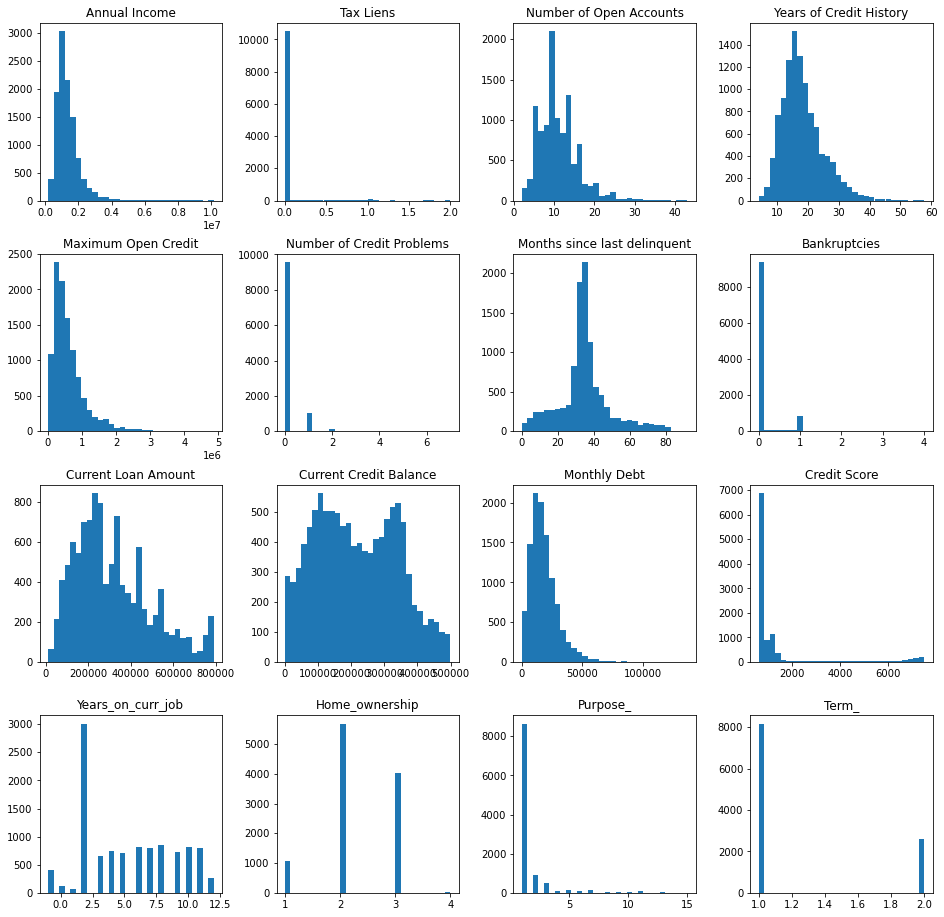

In [132]:
X_train_bal_copy.hist(figsize=(16, 16), bins=30, grid=False);

### Обучение моделей<a class="anchor" id="learning"></a>

In [133]:
X = X_train_bal_copy
#y = df[TARGET_NAME]
y = y_train_balanced

X_train_cb = X_train_bal_copy
y_train_cb = y_train_balanced

X_test = df_test_copy
#y_test = df_test[TARGET_NAME]

In [134]:
len(y_train_cb)

10774

In [135]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   int64  
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   int64  
 6   Months since last delinquent  2500 non-null   float64
 7   Bankruptcies                  2500 non-null   float64
 8   Current Loan Amount           2500 non-null   float64
 9   Current Credit Balance        2500 non-null   float64
 10  Monthly Debt                  2500 non-null   float64
 11  Credit Score                  2500 non-null   float64
 12  Years_on_curr_job             2500 non-null   int64  
 13  Hom

In [136]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_train_cb, y_train_cb,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=42)

In [137]:
CB_FEATURE_NAMES = ['Years_on_curr_job', 'Home_ownership', 'Purpose_', 'Term_']

In [138]:
y_train_cb.value_counts()

0    4336
1    4283
Name: Credit Default, dtype: int64

In [139]:
X_train_cb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8619 entries, 837 to 10272
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 8619 non-null   float32
 1   Tax Liens                     8619 non-null   float16
 2   Number of Open Accounts       8619 non-null   int8   
 3   Years of Credit History       8619 non-null   float16
 4   Maximum Open Credit           8619 non-null   float32
 5   Number of Credit Problems     8619 non-null   int8   
 6   Months since last delinquent  8619 non-null   float16
 7   Bankruptcies                  8619 non-null   float16
 8   Current Loan Amount           8619 non-null   float32
 9   Current Credit Balance        8619 non-null   float32
 10  Monthly Debt                  8619 non-null   float32
 11  Credit Score                  8619 non-null   float16
 12  Years_on_curr_job             8619 non-null   int8   
 13  

In [140]:
disbalance = y_train_cb.value_counts()[0] / y_train_cb.value_counts()[1]
disbalance

1.0123745038524399

In [141]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':42,
     'cat_features':CB_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [142]:
%%time

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=7)
model_catb.fit(X_train_cb, y_train_cb, plot=True, eval_set=(X_test_cb, y_test_cb))

evaluate_preds(model_catb, X_train_cb, X_test_cb, y_train_cb, y_test_cb)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.88      0.79      4336
           1       0.84      0.64      0.72      4283

    accuracy                           0.76      8619
   macro avg       0.78      0.76      0.76      8619
weighted avg       0.78      0.76      0.76      8619

TEST

              precision    recall  f1-score   support

           0       0.69      0.87      0.77      1051
           1       0.84      0.63      0.72      1104

    accuracy                           0.75      2155
   macro avg       0.77      0.75      0.75      2155
weighted avg       0.77      0.75      0.75      2155

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               918  133
1               408  696
CPU times: user 2.41 s, sys: 267 ms, total: 2.68 s
Wall time: 792 ms


In [143]:
#pred_train_bs = model_catb.predict(X_train_bs)
#pred_test_bs = base_model.predict(X_test_bs)
#print()
#print(f"r2 на train: {r2_score(y_train_bs, pred_train_bs)}")
#print(f"r2 на test: {r2_score(y_test_bs, pred_test_bs)}")

    
#pred_bs = base_model.predict(y_train_base)


bs_pred = X_test.drop(columns=X_test.columns).rename_axis('Id')
bs_pred[TARGET_NAME] = model_catb.predict(X_test)

bs_pred.to_csv('predictions.csv', index=True)

bs_pred.head()

,Credit Default
Id,
0,1
1,0
2,1
3,0
4,0


In [144]:
# kaggle score = 0.52670

In [145]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(model_catb, file)

### Снижаем переобучение

In [146]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=7, 
          #                       l2_leaf_reg=.5,
                                reg_lambda=0.3
                                )

model.fit(X_train_cb, y_train_cb, plot=True, eval_set=(X_test_cb, y_test_cb))

evaluate_preds(model, X_train_cb, X_test_cb, y_train_cb, y_test_cb)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.77      0.73      4336
           1       0.74      0.65      0.69      4283

    accuracy                           0.71      8619
   macro avg       0.71      0.71      0.71      8619
weighted avg       0.71      0.71      0.71      8619

TEST

              precision    recall  f1-score   support

           0       0.67      0.77      0.72      1051
           1       0.75      0.65      0.69      1104

    accuracy                           0.71      2155
   macro avg       0.71      0.71      0.70      2155
weighted avg       0.71      0.71      0.70      2155

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               807  244
1               391  713


In [147]:
params = {
    'reg_lambda': np.linspace(0.1, 4, 80)
}

In [148]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=7)

In [149]:
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [150]:
grid_search = model.randomized_search(params,
                                      X_train,
                                      y_train,
                                      n_iter=50,
                                      cv=cv,
                                      stratified=True,
                                      plot=True,
                                      refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3672414339
bestIteration = 8

0:	loss: 0.3672414	best: 0.3672414 (0)	total: 250ms	remaining: 12.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.345469901
bestIteration = 5

1:	loss: 0.3454699	best: 0.3672414 (0)	total: 410ms	remaining: 9.84s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.345469901
bestIteration = 5

2:	loss: 0.3454699	best: 0.3672414 (0)	total: 605ms	remaining: 9.47s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3853549604
bestIteration = 44

3:	loss: 0.3853550	best: 0.3853550 (3)	total: 1.14s	remaining: 13.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.380338984
bestIteration = 24

4:	loss: 0.3803390	best: 0.3853550 (3)	total: 1.45s	remaining: 13.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3876498244
bestIteration = 52

5:	loss: 0.3876498	best: 0.3876498 (5)	total: 2.14s	remaining: 15.7

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3672414339
bestIteration = 8

49:	loss: 0.3672414	best: 0.4325352 (24)	total: 21.3s	remaining: 0us
Estimating final quality...
Stopped by overfitting detector  (20 iterations wait)


In [151]:
grid_search

{'params': {'l2_leaf_reg': 2.0746835443037974},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20],
              'test-F1-mean': [0.4143877988192706,
               0.4057001954420422,
               0.3827663051139015,
               0.38674138884538634,
               0.3631092495878645,
               0.3645506403589413,
               0.3609216717007348,
               0.34872377963001816,
               0.3524848341051305,
               0.35002260739101193,
               0.358321445514626,
               0.3517870229295476,
               0.35074599139517665,
               0.3519552486256101,
      

In [152]:
%%time

evaluate_preds(model, X_train_cb, X_test_cb, y_train_cb, y_test_cb)

TRAIN

              precision    recall  f1-score   support

           0       0.55      0.99      0.71      4336
           1       0.96      0.17      0.29      4283

    accuracy                           0.58      8619
   macro avg       0.75      0.58      0.50      8619
weighted avg       0.75      0.58      0.50      8619

TEST

              precision    recall  f1-score   support

           0       0.53      0.99      0.69      1051
           1       0.95      0.15      0.26      1104

    accuracy                           0.56      2155
   macro avg       0.74      0.57      0.48      2155
weighted avg       0.75      0.56      0.47      2155

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1043    8
1                935  169
CPU times: user 144 ms, sys: 7.95 ms, total: 152 ms
Wall time: 123 ms


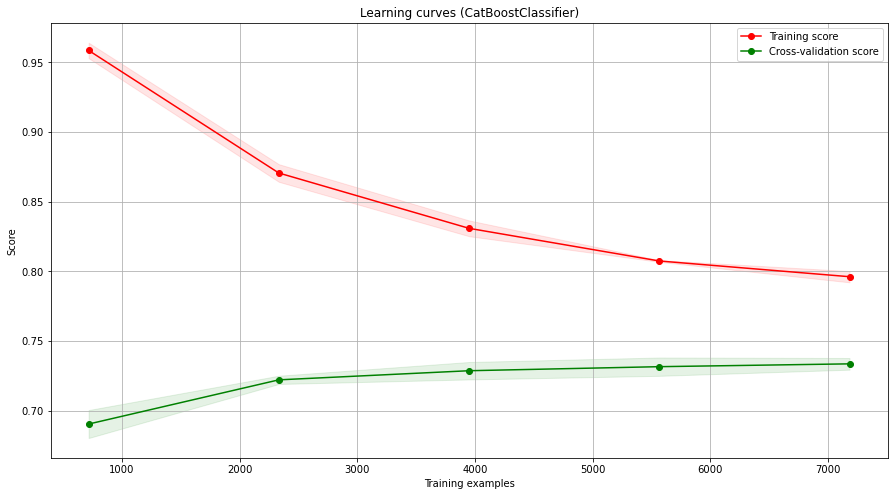

In [153]:
show_learning_curve_plot(model, X, y)

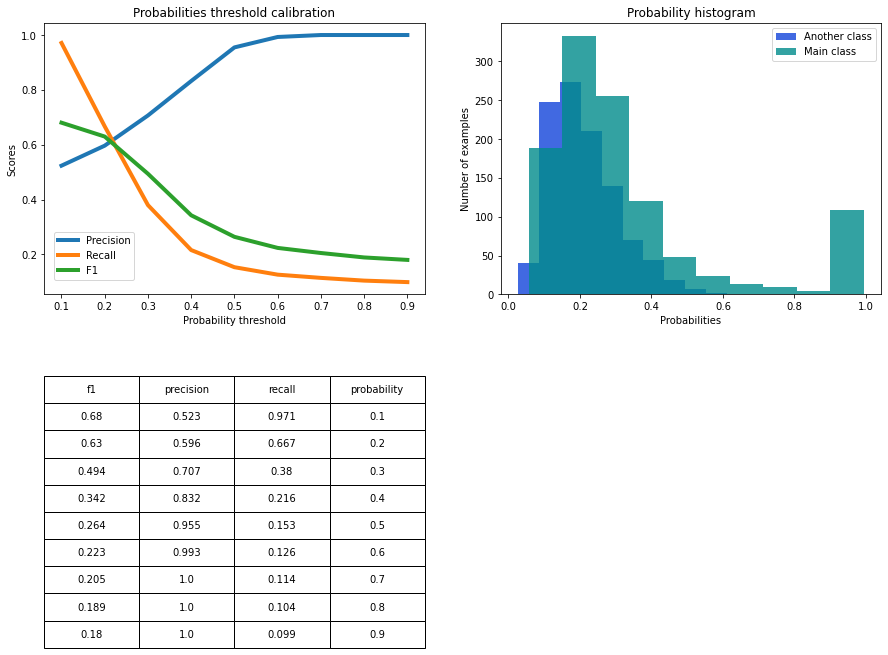

In [154]:
y_test_pred_probs = model.predict_proba(X_test_cb)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test_cb)

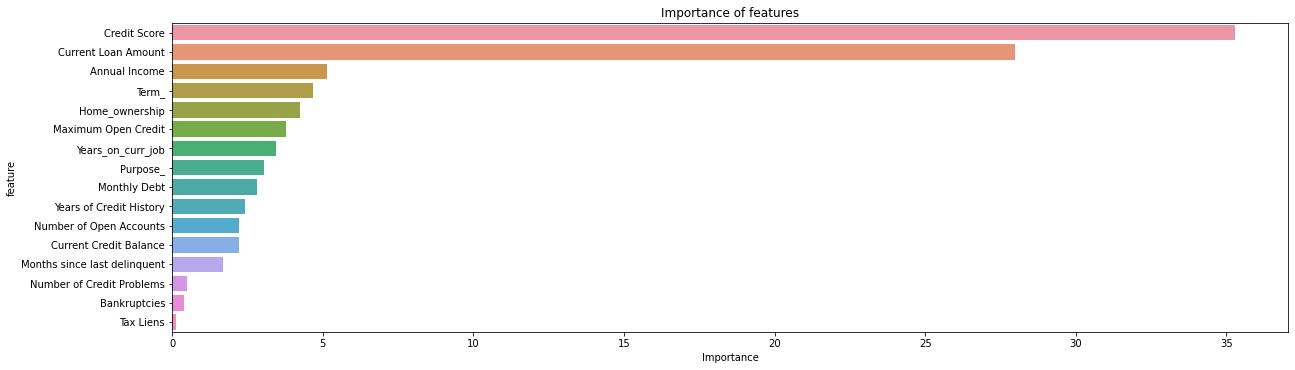

In [155]:
important_features_top = show_feature_importances(X_train_cb.columns, model.feature_importances_, get_top=23)

In [156]:
CB_FEATURE_NAMES

['Years_on_curr_job', 'Home_ownership', 'Purpose_', 'Term_']

In [157]:
NEW_CAT_FEATURE_NAMES = list(set(CB_FEATURE_NAMES).intersection(set(important_features_top)))
NEW_CAT_FEATURE_NAMES

['Years_on_curr_job', 'Home_ownership', 'Purpose_', 'Term_']

In [158]:
X_train_cb[important_features_top]

,Credit Score,Current Loan Amount,Annual Income,Term_,Home_ownership,Maximum Open Credit,Years_on_curr_job,Purpose_,Monthly Debt,Years of Credit History,Number of Open Accounts,Current Credit Balance,Months since last delinquent,Number of Credit Problems,Bankruptcies,Tax Liens
837,737.0,756228.000000,5.131482e+06,1,2,4.860504e+06,11,1,44473.000000,20.703125,16,312773.625000,16.000000,0,0.000000,0.0
10090,728.0,436668.281250,1.032433e+06,2,1,7.298928e+05,2,1,13793.979492,22.718750,12,124013.468750,34.781250,0,0.000000,0.0
4551,1069.0,151844.000000,1.260760e+06,1,3,3.234000e+05,11,1,20982.000000,19.703125,18,76817.000000,18.000000,0,0.000000,0.0
9709,708.0,241868.453125,1.534050e+06,1,2,1.661053e+05,9,1,22177.277344,20.171875,5,139183.546875,41.000000,1,0.652832,0.0
2738,1349.0,155452.000000,1.213317e+06,1,2,2.709740e+05,10,1,24525.000000,10.398438,16,154223.000000,14.000000,0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7572,1020.0,768807.125000,2.826085e+06,1,2,8.410546e+05,2,4,46745.789062,25.046875,15,319836.312500,7.042969,0,0.000000,0.0
5740,734.0,262988.000000,1.287098e+06,1,3,1.970980e+05,2,1,12656.000000,17.296875,5,115748.000000,61.000000,1,1.000000,0.0
274,662.0,237446.000000,9.543890e+05,1,3,1.743940e+05,2,1,16702.000000,12.898438,8,134653.000000,19.000000,0,0.000000,0.0
2855,721.0,97306.000000,6.008940e+05,1,3,4.133360e+05,5,1,16474.000000,13.500000,13,175636.000000,26.000000,1,0.000000,1.0


In [159]:
%%time

frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':NEW_CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

final_model = catb.CatBoostClassifier(**frozen_params,
                                      iterations=300,
                                      max_depth=7,
                                      reg_lambda=0.5)

final_model.fit(X_train_cb[important_features_top], y_train_cb)

evaluate_preds(final_model, X_train_cb[important_features_top], X_test_cb[important_features_top], y_train_cb, y_test_cb)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      4336
           1       0.89      0.71      0.79      4283

    accuracy                           0.81      8619
   macro avg       0.83      0.81      0.81      8619
weighted avg       0.83      0.81      0.81      8619

TEST

              precision    recall  f1-score   support

           0       0.71      0.87      0.78      1051
           1       0.85      0.66      0.74      1104

    accuracy                           0.76      2155
   macro avg       0.78      0.77      0.76      2155
weighted avg       0.78      0.76      0.76      2155

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               919  132
1               376  728
CPU times: user 12.3 s, sys: 1.12 s, total: 13.4 s
Wall time: 2.95 s


In [160]:
X_test[important_features_top]

,Credit Score,Current Loan Amount,Annual Income,Term_,Home_ownership,Maximum Open Credit,Years_on_curr_job,Purpose_,Monthly Debt,Years of Credit History,Number of Open Accounts,Current Credit Balance,Months since last delinquent,Number of Credit Problems,Bankruptcies,Tax Liens
0,1189.370639,162470.000000,8.463080e+05,1,1,220968.0,1,1,6813.0,12.5,9,1.059060e+05,70.000000,0,0.0,0.0
1,699.000000,78298.000000,2.318380e+05,1,1,55946.0,2,2,2318.0,32.7,6,4.603700e+04,8.000000,0,0.0,0.0
2,7260.000000,200178.000000,1.152540e+06,1,2,204600.0,3,1,18729.0,13.7,10,1.464900e+05,33.912691,0,0.0,0.0
3,739.000000,217382.000000,1.220313e+06,1,2,456302.0,4,1,27559.0,17.0,16,2.131990e+05,70.000000,0,0.0,0.0
4,706.000000,777634.000000,2.340952e+06,2,2,1207272.0,5,1,42605.0,23.6,11,4.253910e+05,30.342944,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,745.000000,503076.610977,1.020053e+06,1,2,559152.0,4,1,15046.0,29.1,14,1.627350e+05,68.000000,1,1.0,0.0
2496,1167.267972,468512.000000,2.047360e+06,1,2,1737780.0,8,1,32996.0,17.0,15,9.055860e+05,77.000000,0,0.0,0.0
2497,695.000000,430496.000000,1.171806e+06,1,2,1706430.0,8,1,36912.0,12.8,48,8.558413e+05,33.781124,0,0.0,0.0
2498,744.000000,257774.000000,7.235200e+05,1,1,945780.0,4,1,13506.0,28.8,14,3.912480e+05,32.124015,0,0.0,0.0


In [161]:
bs_pred = X_test.drop(columns=X_test.columns).rename_axis('Id')
bs_pred[TARGET_NAME] = final_model.predict(X_test[important_features_top])
bs_pred.to_csv('final_predictions.csv', index=True)
bs_pred.head()

,Credit Default
Id,
0,1
1,0
2,1
3,0
4,0


In [162]:
# kaggle_score = 0.50467

In [163]:
with open(FINAL_MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)